In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
import pickle
import numpy as np
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs

# Utils

In [3]:
def plot_gain_dist_by_episode(names, labels=None, title=None, wind_dirs=[45, 90, 135, 180, 225, 270, 315]):
  if not isinstance(names, list):
    names = [names]

  n_envs = len(wind_dirs)
  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  for env_id, wind_dir in enumerate(wind_dirs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Wind dir: {wind_dir}°')
    plot_metric(
      [f'{name}-{env_id}/0' for name in names],
      metric='obs/cum_obs/gain_dist/0',
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True,
      plot_type='mean')

  for i, name in enumerate(names):
    if labels is not None:
      label = labels[i]
    else:
      label = name
    axs[1, 3].plot([], [], label=label)

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=len(names))

In [4]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)

  scores_by_wind = defaultdict(list)
  scores_by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/eval-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/gain_dist/0'].iloc[-1]
      scores_by_wind[wind_dir].append(score)
      scores_by_step[step].append(score)

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['policy_kwargs', 'name', 'env_name', 'seed', 'reward_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score']
  for step, scores in scores_by_step.items():
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores)])
  print(pt)
  print()

  steps = list(sorted(steps))
  plt.figure(figsize=(4, 4), dpi=150)
  for wind_dir in wind_dirs:
    scores = scores_by_wind[wind_dir]
    plt.plot(steps, scores, label=f'{wind_dir}°')
  plt.xlabel('Training step')
  plt.ylabel('Cum. dist.')
  plt.title(name)
  # right legend
  plt.legend(bbox_to_anchor=(1.05, .5), loc='center left')

In [5]:
# def extract_step(filename):
#   res = re.search(r'(\d+)$', filename)
#   return int(res.group(1))

# files = glob('../runs/08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1*')
# files = sorted(files, key=extract_step)

# plot_gain_dist_by_episode(
#   names=[f'{f}/eval-*' for f in files],
#   labels=[f'{round(extract_step(f)/1e3)}K'  for f in files]
# )

# Reflexions

## VMC > gain_dist (maybe)
VMC seems better than gain_dist because it is more stable

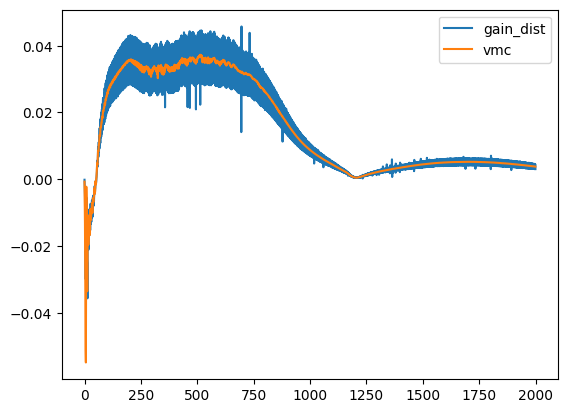

In [30]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/gain_dist/0'].plot(label='gain_dist')
(df['obs/vmc/0']*.1).plot(label='vmc')
plt.legend()

## Remove noisy sensors

- **TAE -> heading error**: TAE is really noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).

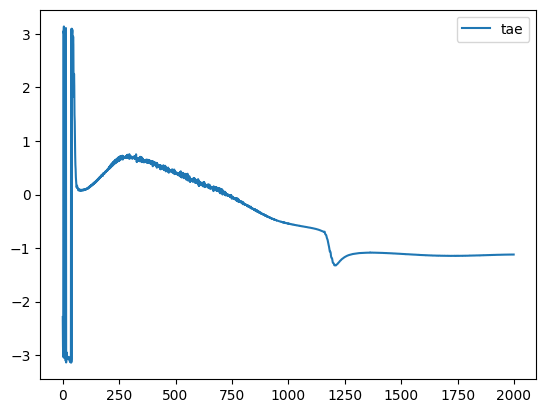

In [40]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/tae/0'].plot(label='tae')
plt.legend()

## $\lvert \dot\theta_{rudder} \rvert \leq 6$

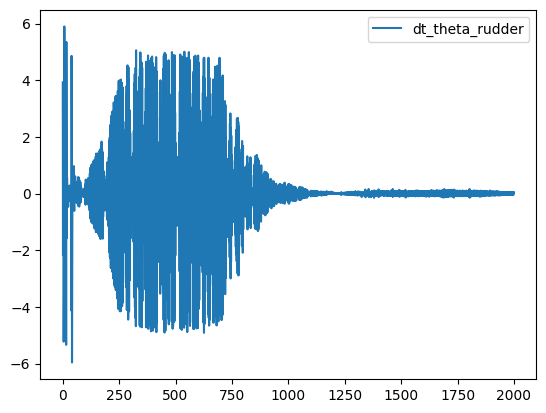

In [45]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='dt_theta_rudder')
plt.legend()

# $\lvert VMC \rvert \lessapprox .4$

<Axes: >

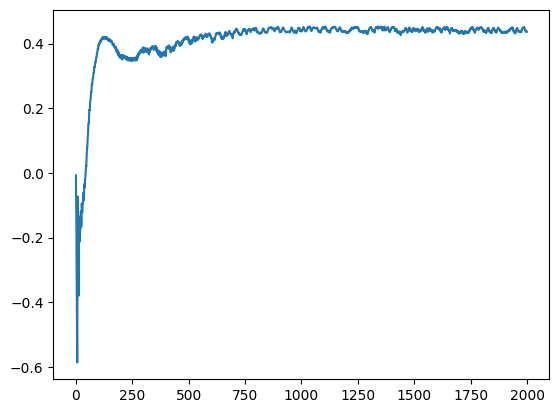

In [49]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-1/0')
df = dfs.popitem()[1]
df['obs/vmc/0'].plot()

# Eval 1M steps with best hyperparams
- **Result:** degredation of performance
- **Hypothesis:** the observation was too big and possibly noisy

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v3          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 8                 |
|       gamma       |               0.999               |
|   l

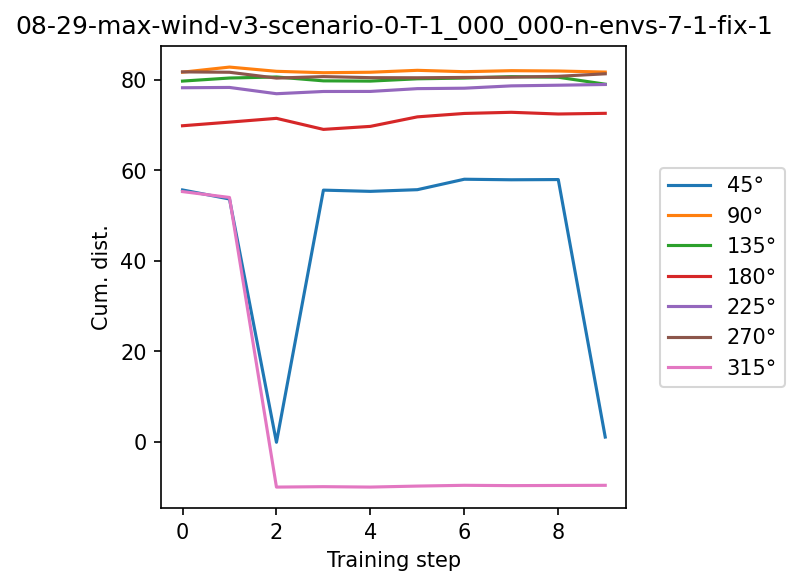

In [196]:
plot_training_evolution('08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1', model_folder='08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1')

# Testing with smaller observation space (basic_2d_obs_v4) & trying with different episode duration

- **Result:** 
- **Hypothesis:** 

## Episode duration = **200s**

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A"

screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

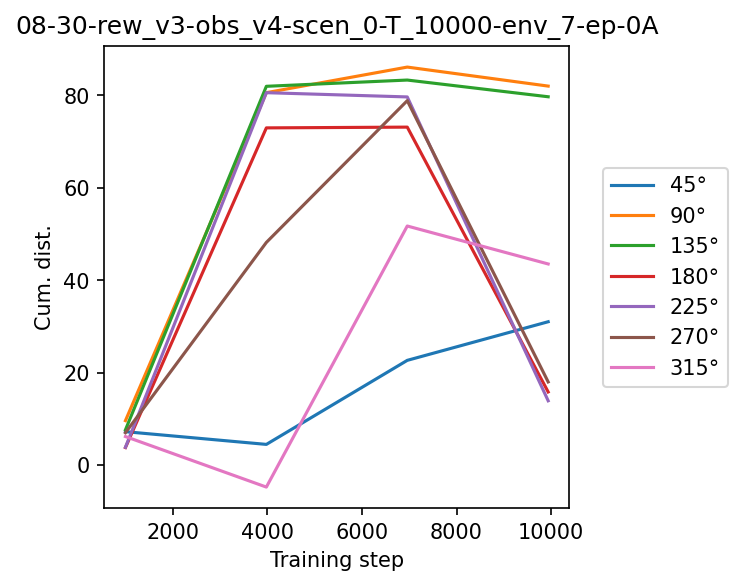

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                200                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

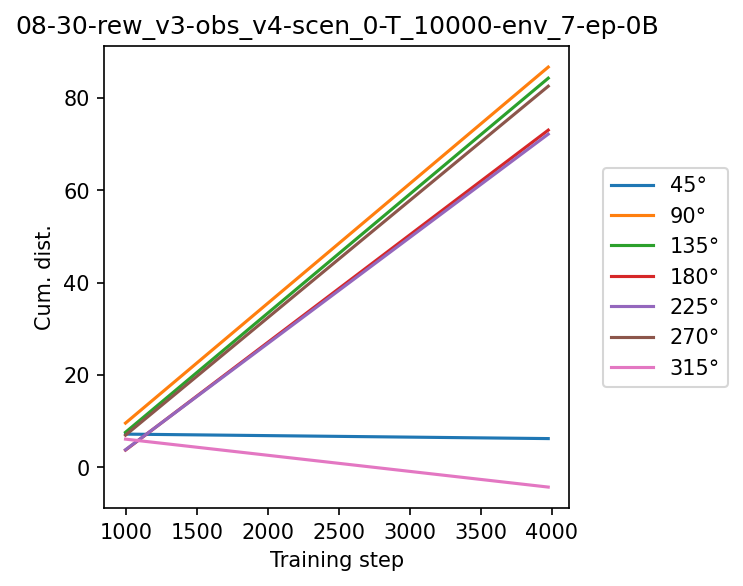

In [46]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B')

## Episode duration = **100s**

```bash
screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A"

screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

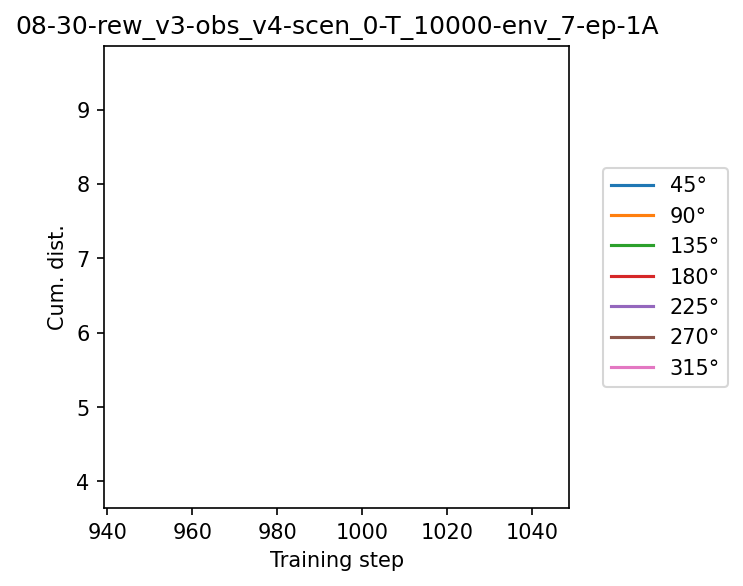

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                100                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

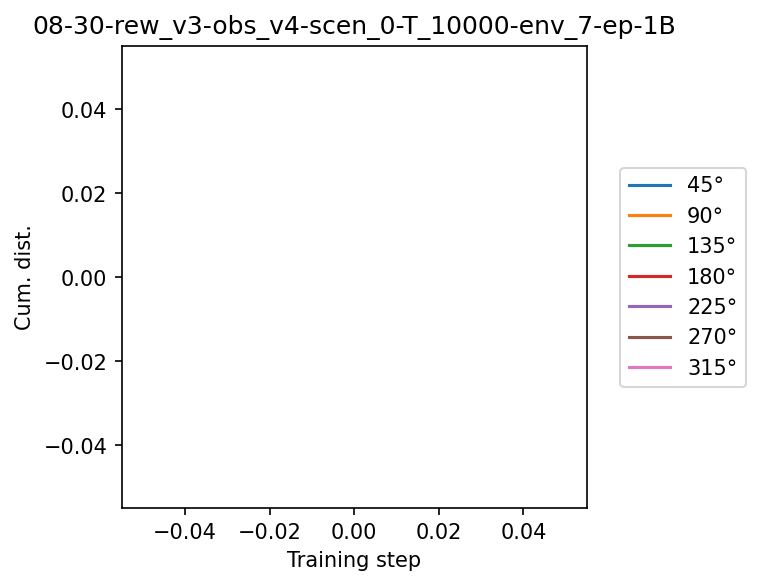

In [12]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B')

## Episode duration = **50**

```bash
screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A"

screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B"
```

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                 50                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

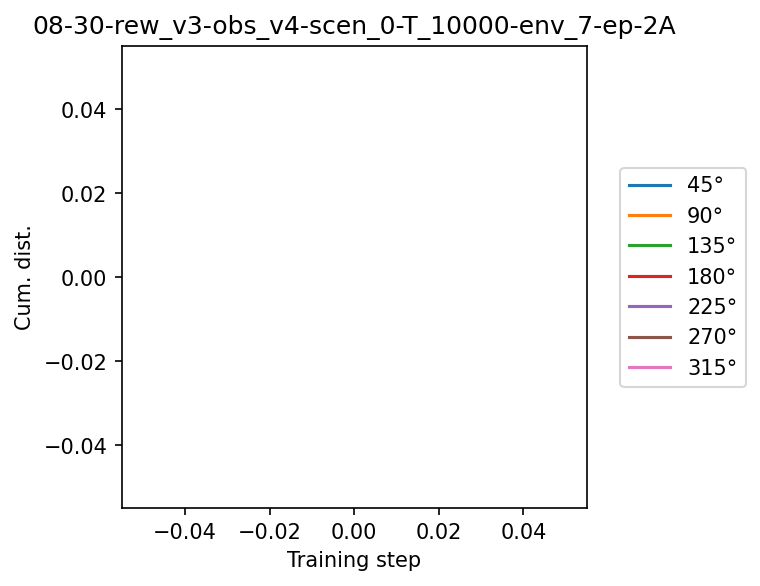

Hparams:
+-------------------+-----------------------------------+
|        Name       |               Value               |
+-------------------+-----------------------------------+
|        obs        |          basic_2d_obs_v4          |
|        act        |          rudder_angle_act         |
|       reward      |            max_dist_v3            |
|  episode_duration |                 50                |
|       n_envs      |                 7                 |
|   water_current   |                none               |
|        wind       |              constant             |
|     wind_dirs     | [45, 90, 135, 180, 225, 270, 315] |
| water_current_dir |                 90                |
|  keep_sim_running |               False               |
|   container_tag   |              mss1-ode             |
|      n_steps      |                1024               |
|     batch_size    |                 32                |
|       gamma       |               0.999               |
|   l

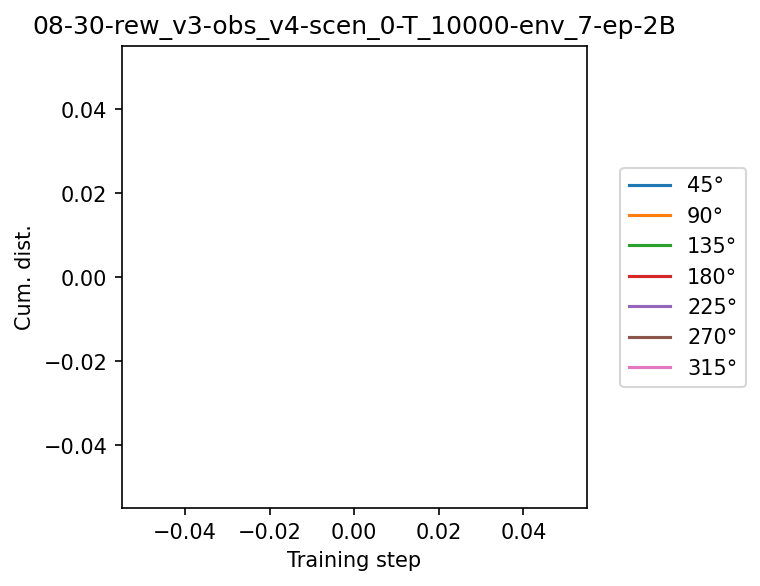

In [210]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B')